In [ ]:
%matplotlib inline

import os

from __future__ import division
import random
import numpy as np
import keras
import tensorflow as tf


import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import cv2
from google.colab.patches import cv2_imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Lambda, Activation, Conv2D, MaxPooling2D, ZeroPadding2D, Reshape, Concatenate, Dense, Dropout, Flatten
import keras.backend as K
from keras.regularizers import l2


vgg = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=True)

transfer_layer_bc43 = vgg.get_layer('block4_conv3')

transfer_layer_bp5 = vgg.get_layer('block5_pool')

vgg_model_bc43 = Model(inputs = vgg.input, outputs = transfer_layer_bc43.output)
vgg_model_bp5 = Model(inputs = vgg.input, outputs = transfer_layer_bp5.output)

vgg_model_bc43.trainable = False
vgg_model_bp5.trainable = False

for layer in vgg_model_bc43.layers:
  layer.trainable = False

for layer in vgg_model_bp5.layers:
  layer.trainable = False

# vgg_model_bc43.summary()
vgg_model_bp5.summary()
 


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

drive/MyDrive/Colab Notebooks/images


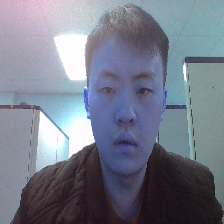

AttributeError: ignored

In [ ]:
paths = {'image_path':os.path.join('drive', 'MyDrive', 'Colab Notebooks', 'images')}
print(paths['image_path'])
img = image.load_img(os.path.join(paths['image_path'], 'EE484_1.jpg'), target_size=(224, 224))
x = image.img_to_array(img)
# x = cv2.imread(os.path.join(paths['image_path'], 'EE484_1.jpg'))
cv2_imshow(x)

y_bp5 = vgg_model_bp5(x.reshape(-1, 224, 224, 3))
y_bc43 = vgg_model_bc43(x.reshape(-1, 224, 224, 3))


In [ ]:

!cp /content/drive/MyDrive/Colab\ Notebooks/keras_layer_anchorboxes.py /content
from keras_layer_anchorboxes import AnchorBoxes

!cp /content/drive/MyDrive/Colab\ Notebooks/keras_layer_L2Normalization.py /content
from keras_layer_L2Normalization import L2Normalization



In [ ]:
Image_size = (224, 224, 3)
n_classes = 10
mean_color = [123, 117, 104]
swap_channels = [2, 1, 0]
scales_pascal = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05]
scales = scales_pascal
two_boxes_for_ar1 = True
steps = [8, 16, 32, 64, 100, 300]
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
clip_boxes = False
variances = [0.1, 0.1, 0.2, 0.2]
normalize_coords = True

def ssd_300(image_size,
            n_classes,
            mode='training',
            l2_regularization=0.0005,
            min_scale=None,
            max_scale=None,
            scales=None,
            aspect_ratios_global=None,
            aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
                                     [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                     [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                     [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                     [1.0, 2.0, 0.5],
                                     [1.0, 2.0, 0.5]],
            two_boxes_for_ar1=True,
            steps=[8, 16, 32, 64, 100, 300],
            offsets=None,
            clip_boxes=False,
            variances=[0.1, 0.1, 0.2, 0.2],
            coords='centroids',
            normalize_coords=True,
            subtract_mean=[123, 117, 104],
            divide_by_stddev=None,
            swap_channels=[2, 1, 0],
            confidence_thresh=0.01,
            iou_threshold=0.45,
            top_k=200,
            nms_max_output_size=400,
            return_predictor_sizes=False):


    n_predictor_layers = 6 # The number of predictor conv layers in the network is 6 for the original SSD300.
    n_classes += 1 # Account for the background class. (Empty one)
    l2_reg = l2_regularization # Make the internal name shorter.
    img_height, img_width, img_channels = image_size[0], image_size[1], image_size[2]

    ############################################################################
    # Get a few exceptions out of the way.
    ############################################################################

    if aspect_ratios_global is None and aspect_ratios_per_layer is None:
        raise ValueError("`aspect_ratios_global` and `aspect_ratios_per_layer` cannot both be None. At least one needs to be specified.")
    if aspect_ratios_per_layer:
        if len(aspect_ratios_per_layer) != n_predictor_layers:
            raise ValueError("It must be either aspect_ratios_per_layer is None or len(aspect_ratios_per_layer) == {}, but len(aspect_ratios_per_layer) == {}.".format(n_predictor_layers, len(aspect_ratios_per_layer)))

    if (min_scale is None or max_scale is None) and scales is None:
        raise ValueError("Either `min_scale` and `max_scale` or `scales` need to be specified.")
    if scales:
        if len(scales) != n_predictor_layers+1:
            raise ValueError("It must be either scales is None or len(scales) == {}, but len(scales) == {}.".format(n_predictor_layers+1, len(scales)))
    else: # If no explicit list of scaling factors was passed, compute the list of scaling factors from `min_scale` and `max_scale`
        scales = np.linspace(min_scale, max_scale, n_predictor_layers+1)

    if len(variances) != 4:
        raise ValueError("4 variance values must be pased, but {} values were received.".format(len(variances)))
    variances = np.array(variances)
    if np.any(variances <= 0):
        raise ValueError("All variances must be >0, but the variances given are {}".format(variances))

    if (not (steps is None)) and (len(steps) != n_predictor_layers):
        raise ValueError("You must provide at least one step value per predictor layer.")

    if (not (offsets is None)) and (len(offsets) != n_predictor_layers):
        raise ValueError("You must provide at least one offset value per predictor layer.")

    ############################################################################
    # Compute the anchor box parameters.
    ############################################################################

    # Set the aspect ratios for each predictor layer. These are only needed for the anchor box layers.
    if aspect_ratios_per_layer:
        aspect_ratios = aspect_ratios_per_layer
    else:
        aspect_ratios = [aspect_ratios_global] * n_predictor_layers

    # Compute the number of boxes to be predicted per cell for each predictor layer.
    # We need this so that we know how many channels the predictor layers need to have.
    if aspect_ratios_per_layer:
        n_boxes = []
        for ar in aspect_ratios_per_layer:
            if (1 in ar) & two_boxes_for_ar1:
                n_boxes.append(len(ar) + 1) # +1 for the second box for aspect ratio 1
            else:
                n_boxes.append(len(ar))
    else: # If only a global aspect ratio list was passed, then the number of boxes is the same for each predictor layer
        if (1 in aspect_ratios_global) & two_boxes_for_ar1:
            n_boxes = len(aspect_ratios_global) + 1
        else:
            n_boxes = len(aspect_ratios_global)
        n_boxes = [n_boxes] * n_predictor_layers

    if steps is None:
        steps = [None] * n_predictor_layers
    if offsets is None:
        offsets = [None] * n_predictor_layers

    ############################################################################
    # Define functions for the Lambda layers below.
    ############################################################################

    def identity_layer(tensor):
        return tensor

    def input_mean_normalization(tensor):
        return tensor - np.array(subtract_mean)

    def input_stddev_normalization(tensor):
        return tensor / np.array(divide_by_stddev)

    def input_channel_swap(tensor):
        if len(swap_channels) == 3:
            return K.stack([tensor[...,swap_channels[0]], tensor[...,swap_channels[1]], tensor[...,swap_channels[2]]], axis=-1)
        elif len(swap_channels) == 4:
            return K.stack([tensor[...,swap_channels[0]], tensor[...,swap_channels[1]], tensor[...,swap_channels[2]], tensor[...,swap_channels[3]]], axis=-1)

    ############################################################################
    # Build the network.
    ############################################################################

    x = Input(shape=(img_height, img_width, img_channels))

    # The following identity layer is only needed so that the subsequent lambda layers can be optional.
    x1 = Lambda(identity_layer, output_shape=(img_height, img_width, img_channels), name='identity_layer')(x)
    if not (subtract_mean is None):
        x1 = Lambda(input_mean_normalization, output_shape=(img_height, img_width, img_channels), name='input_mean_normalization')(x1)
    if not (divide_by_stddev is None):
        x1 = Lambda(input_stddev_normalization, output_shape=(img_height, img_width, img_channels), name='input_stddev_normalization')(x1)
    if swap_channels:
        x1 = Lambda(input_channel_swap, output_shape=(img_height, img_width, img_channels), name='input_channel_swap')(x1)

    # conv1_1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv1_1')(x1)
    # conv1_2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv1_2')(conv1_1)
    # pool1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool1')(conv1_2)

    # conv2_1 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv2_1')(pool1)
    # conv2_2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv2_2')(conv2_1)
    # pool2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool2')(conv2_2)

    # conv3_1 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv3_1')(pool2)
    # conv3_2 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv3_2')(conv3_1)
    # conv3_3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv3_3')(conv3_2)
    # pool3 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool3')(conv3_3)

    # conv4_1 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv4_1')(pool3)
    # conv4_2 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv4_2')(conv4_1)
    # conv4_3 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv4_3')(conv4_2)
    # pool4 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool4')(conv4_3)

    # conv5_1 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv5_1')(pool4)
    # conv5_2 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv5_2')(conv5_1)
    # conv5_3 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv5_3')(conv5_2)
    # pool5 = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same', name='pool5')(conv5_3)
    
    conv4_3 = vgg_model_bc43(x1)
    pool5 = vgg_model_bp5(x1)

    fc6 = Conv2D(1024, (3, 3), dilation_rate=(6, 6), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='fc6')(pool5)

    fc7 = Conv2D(1024, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='fc7')(fc6)

    conv6_1 = Conv2D(256, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv6_1')(fc7)
    conv6_1 = ZeroPadding2D(padding=((1, 1), (1, 1)), name='conv6_padding')(conv6_1)
    conv6_2 = Conv2D(512, (3, 3), strides=(2, 2), activation='relu', padding='valid', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv6_2')(conv6_1)

    conv7_1 = Conv2D(128, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv7_1')(conv6_2)
    conv7_1 = ZeroPadding2D(padding=((1, 1), (1, 1)), name='conv7_padding')(conv7_1)
    conv7_2 = Conv2D(256, (3, 3), strides=(2, 2), activation='relu', padding='valid', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv7_2')(conv7_1)

    conv8_1 = Conv2D(128, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv8_1')(conv7_2)
    conv8_2 = Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='valid', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv8_2')(conv8_1)

    conv9_1 = Conv2D(128, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv9_1')(conv8_2)
    conv9_2 = Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='valid', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv9_2')(conv9_1)

    # Feed conv4_3 into the L2 normalization layer
    conv4_3_norm = L2Normalization(gamma_init=20, name='conv4_3_norm')(conv4_3)

    ### Build the convolutional predictor layers on top of the base network

    # We precidt `n_classes` confidence values for each box, hence the confidence predictors have depth `n_boxes * n_classes`
    # Output shape of the confidence layers: `(batch, height, width, n_boxes * n_classes)`
    conv4_3_norm_mbox_conf = Conv2D(n_boxes[0] * n_classes, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv4_3_norm_mbox_conf')(conv4_3_norm)
    fc7_mbox_conf = Conv2D(n_boxes[1] * n_classes, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='fc7_mbox_conf')(fc7)
    conv6_2_mbox_conf = Conv2D(n_boxes[2] * n_classes, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv6_2_mbox_conf')(conv6_2)
    conv7_2_mbox_conf = Conv2D(n_boxes[3] * n_classes, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv7_2_mbox_conf')(conv7_2)
    conv8_2_mbox_conf = Conv2D(n_boxes[4] * n_classes, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv8_2_mbox_conf')(conv8_2)
    conv9_2_mbox_conf = Conv2D(n_boxes[5] * n_classes, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv9_2_mbox_conf')(conv9_2)
    # We predict 4 box coordinates for each box, hence the localization predictors have depth `n_boxes * 4`
    # Output shape of the localization layers: `(batch, height, width, n_boxes * 4)`
    conv4_3_norm_mbox_loc = Conv2D(n_boxes[0] * 4, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv4_3_norm_mbox_loc')(conv4_3_norm)
    fc7_mbox_loc = Conv2D(n_boxes[1] * 4, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='fc7_mbox_loc')(fc7)
    conv6_2_mbox_loc = Conv2D(n_boxes[2] * 4, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv6_2_mbox_loc')(conv6_2)
    conv7_2_mbox_loc = Conv2D(n_boxes[3] * 4, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv7_2_mbox_loc')(conv7_2)
    conv8_2_mbox_loc = Conv2D(n_boxes[4] * 4, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv8_2_mbox_loc')(conv8_2)
    conv9_2_mbox_loc = Conv2D(n_boxes[5] * 4, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv9_2_mbox_loc')(conv9_2)

    ### Generate the anchor boxes (called "priors" in the original Caffe/C++ implementation, so I'll keep their layer names)

    # Output shape of anchors: `(batch, height, width, n_boxes, 8)`
    conv4_3_norm_mbox_priorbox = AnchorBoxes(img_height, img_width, this_scale=scales[0], next_scale=scales[1], aspect_ratios=aspect_ratios[0],
                                             two_boxes_for_ar1=two_boxes_for_ar1, this_steps=steps[0], this_offsets=offsets[0], clip_boxes=clip_boxes,
                                             variances=variances, coords=coords, normalize_coords=normalize_coords, name='conv4_3_norm_mbox_priorbox')(conv4_3_norm_mbox_loc)
    fc7_mbox_priorbox = AnchorBoxes(img_height, img_width, this_scale=scales[1], next_scale=scales[2], aspect_ratios=aspect_ratios[1],
                                    two_boxes_for_ar1=two_boxes_for_ar1, this_steps=steps[1], this_offsets=offsets[1], clip_boxes=clip_boxes,
                                    variances=variances, coords=coords, normalize_coords=normalize_coords, name='fc7_mbox_priorbox')(fc7_mbox_loc)
    conv6_2_mbox_priorbox = AnchorBoxes(img_height, img_width, this_scale=scales[2], next_scale=scales[3], aspect_ratios=aspect_ratios[2],
                                        two_boxes_for_ar1=two_boxes_for_ar1, this_steps=steps[2], this_offsets=offsets[2], clip_boxes=clip_boxes,
                                        variances=variances, coords=coords, normalize_coords=normalize_coords, name='conv6_2_mbox_priorbox')(conv6_2_mbox_loc)
    conv7_2_mbox_priorbox = AnchorBoxes(img_height, img_width, this_scale=scales[3], next_scale=scales[4], aspect_ratios=aspect_ratios[3],
                                        two_boxes_for_ar1=two_boxes_for_ar1, this_steps=steps[3], this_offsets=offsets[3], clip_boxes=clip_boxes,
                                        variances=variances, coords=coords, normalize_coords=normalize_coords, name='conv7_2_mbox_priorbox')(conv7_2_mbox_loc)
    conv8_2_mbox_priorbox = AnchorBoxes(img_height, img_width, this_scale=scales[4], next_scale=scales[5], aspect_ratios=aspect_ratios[4],
                                        two_boxes_for_ar1=two_boxes_for_ar1, this_steps=steps[4], this_offsets=offsets[4], clip_boxes=clip_boxes,
                                        variances=variances, coords=coords, normalize_coords=normalize_coords, name='conv8_2_mbox_priorbox')(conv8_2_mbox_loc)
    conv9_2_mbox_priorbox = AnchorBoxes(img_height, img_width, this_scale=scales[5], next_scale=scales[6], aspect_ratios=aspect_ratios[5],
                                        two_boxes_for_ar1=two_boxes_for_ar1, this_steps=steps[5], this_offsets=offsets[5], clip_boxes=clip_boxes,
                                        variances=variances, coords=coords, normalize_coords=normalize_coords, name='conv9_2_mbox_priorbox')(conv9_2_mbox_loc)

    ### Reshape

    # Reshape the class predictions, yielding 3D tensors of shape `(batch, height * width * n_boxes, n_classes)`
    # We want the classes isolated in the last axis to perform softmax on them
    conv4_3_norm_mbox_conf_reshape = Reshape((-1, n_classes), name='conv4_3_norm_mbox_conf_reshape')(conv4_3_norm_mbox_conf)
    fc7_mbox_conf_reshape = Reshape((-1, n_classes), name='fc7_mbox_conf_reshape')(fc7_mbox_conf)
    conv6_2_mbox_conf_reshape = Reshape((-1, n_classes), name='conv6_2_mbox_conf_reshape')(conv6_2_mbox_conf)
    conv7_2_mbox_conf_reshape = Reshape((-1, n_classes), name='conv7_2_mbox_conf_reshape')(conv7_2_mbox_conf)
    conv8_2_mbox_conf_reshape = Reshape((-1, n_classes), name='conv8_2_mbox_conf_reshape')(conv8_2_mbox_conf)
    conv9_2_mbox_conf_reshape = Reshape((-1, n_classes), name='conv9_2_mbox_conf_reshape')(conv9_2_mbox_conf)
    # Reshape the box predictions, yielding 3D tensors of shape `(batch, height * width * n_boxes, 4)`
    # We want the four box coordinates isolated in the last axis to compute the smooth L1 loss
    conv4_3_norm_mbox_loc_reshape = Reshape((-1, 4), name='conv4_3_norm_mbox_loc_reshape')(conv4_3_norm_mbox_loc)
    fc7_mbox_loc_reshape = Reshape((-1, 4), name='fc7_mbox_loc_reshape')(fc7_mbox_loc)
    conv6_2_mbox_loc_reshape = Reshape((-1, 4), name='conv6_2_mbox_loc_reshape')(conv6_2_mbox_loc)
    conv7_2_mbox_loc_reshape = Reshape((-1, 4), name='conv7_2_mbox_loc_reshape')(conv7_2_mbox_loc)
    conv8_2_mbox_loc_reshape = Reshape((-1, 4), name='conv8_2_mbox_loc_reshape')(conv8_2_mbox_loc)
    conv9_2_mbox_loc_reshape = Reshape((-1, 4), name='conv9_2_mbox_loc_reshape')(conv9_2_mbox_loc)
    # Reshape the anchor box tensors, yielding 3D tensors of shape `(batch, height * width * n_boxes, 8)`
    conv4_3_norm_mbox_priorbox_reshape = Reshape((-1, 8), name='conv4_3_norm_mbox_priorbox_reshape')(conv4_3_norm_mbox_priorbox)
    fc7_mbox_priorbox_reshape = Reshape((-1, 8), name='fc7_mbox_priorbox_reshape')(fc7_mbox_priorbox)
    conv6_2_mbox_priorbox_reshape = Reshape((-1, 8), name='conv6_2_mbox_priorbox_reshape')(conv6_2_mbox_priorbox)
    conv7_2_mbox_priorbox_reshape = Reshape((-1, 8), name='conv7_2_mbox_priorbox_reshape')(conv7_2_mbox_priorbox)
    conv8_2_mbox_priorbox_reshape = Reshape((-1, 8), name='conv8_2_mbox_priorbox_reshape')(conv8_2_mbox_priorbox)
    conv9_2_mbox_priorbox_reshape = Reshape((-1, 8), name='conv9_2_mbox_priorbox_reshape')(conv9_2_mbox_priorbox)

    ### Concatenate the predictions from the different layers

    # Axis 0 (batch) and axis 2 (n_classes or 4, respectively) are identical for all layer predictions,
    # so we want to concatenate along axis 1, the number of boxes per layer
    # Output shape of `mbox_conf`: (batch, n_boxes_total, n_classes)
    mbox_conf = Concatenate(axis=1, name='mbox_conf')([conv4_3_norm_mbox_conf_reshape,
                                                       fc7_mbox_conf_reshape,
                                                       conv6_2_mbox_conf_reshape,
                                                       conv7_2_mbox_conf_reshape,
                                                       conv8_2_mbox_conf_reshape,
                                                       conv9_2_mbox_conf_reshape])

    # Output shape of `mbox_loc`: (batch, n_boxes_total, 4)
    mbox_loc = Concatenate(axis=1, name='mbox_loc')([conv4_3_norm_mbox_loc_reshape,
                                                     fc7_mbox_loc_reshape,
                                                     conv6_2_mbox_loc_reshape,
                                                     conv7_2_mbox_loc_reshape,
                                                     conv8_2_mbox_loc_reshape,
                                                     conv9_2_mbox_loc_reshape])

    # Output shape of `mbox_priorbox`: (batch, n_boxes_total, 8)
    mbox_priorbox = Concatenate(axis=1, name='mbox_priorbox')([conv4_3_norm_mbox_priorbox_reshape,
                                                               fc7_mbox_priorbox_reshape,
                                                               conv6_2_mbox_priorbox_reshape,
                                                               conv7_2_mbox_priorbox_reshape,
                                                               conv8_2_mbox_priorbox_reshape,
                                                               conv9_2_mbox_priorbox_reshape])

    # The box coordinate predictions will go into the loss function just the way they are,
    # but for the class predictions, we'll apply a softmax activation layer first
    mbox_conf_softmax = Activation('softmax', name='mbox_conf_softmax')(mbox_conf)

    # Concatenate the class and box predictions and the anchors to one large predictions vector
    # Output shape of `predictions`: (batch, n_boxes_total, n_classes + 4 + 8)
    predictions = Concatenate(axis=2, name='predictions')([mbox_conf_softmax, mbox_loc, mbox_priorbox])

    if mode == 'training':
        model = Model(inputs=x, outputs=predictions)
    """
	elif mode == 'inference':
        decoded_predictions = DecodeDetections(confidence_thresh=confidence_thresh,
                                               iou_threshold=iou_threshold,
                                               top_k=top_k,
                                               nms_max_output_size=nms_max_output_size,
                                               coords=coords,
                                               normalize_coords=normalize_coords,
                                               img_height=img_height,
                                               img_width=img_width,
                                               name='decoded_predictions')(predictions)
        model = Model(inputs=x, outputs=decoded_predictions)
    elif mode == 'inference_fast':
        decoded_predictions = DecodeDetectionsFast(confidence_thresh=confidence_thresh,
                                                   iou_threshold=iou_threshold,
                                                   top_k=top_k,
                                                   nms_max_output_size=nms_max_output_size,
                                                   coords=coords,
                                                   normalize_coords=normalize_coords,
                                                   img_height=img_height,
                                                   img_width=img_width,
                                                   name='decoded_predictions')(predictions)
        model = Model(inputs=x, outputs=decoded_predictions) 
    else:
        raise ValueError("`mode` must be one of 'training', 'inference' or 'inference_fast', but received '{}'.".format(mode))
    """
    if return_predictor_sizes:
        predictor_sizes = np.array([conv4_3_norm_mbox_conf._keras_shape[1:3],
                                     fc7_mbox_conf._keras_shape[1:3],
                                     conv6_2_mbox_conf._keras_shape[1:3],
                                     conv7_2_mbox_conf._keras_shape[1:3],
                                     conv8_2_mbox_conf._keras_shape[1:3],
                                     conv9_2_mbox_conf._keras_shape[1:3]])
        return model, predictor_sizes
    else:
        return model
